In [12]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [ ]:
class PredictionModel:

    def __init__(self, mu_samples, sigma_samples, R, N):
        self.R = R
        self.N = N

        ws = []
        t = np.arange(1, 25)

        for mu, sigma in zip(mu_samples, sigma_samples):
            theta = sigma**2 / mu
            k = mu / theta
            w = scipy.stats.gamma(k, scale=theta).pdf(t)
            ws.append(w)

        self.ws = ws

    def simulate(self, w, infection_history, duration):
        
        simulated_incidence = copy.copy(infection_history)
        simulated_incidence = list(simulated_incidence)
        
        for t in range(duration):
            
            if len(w) > len(simulated_incidence):
                potential = w[:len(simulated_incidence)] @ simulated_incidence[::-1]

            elif len(w) <= len(simulated_incidence):
                potential = w @ simulated_incidence[::-1][:len(w)]

            proportion_susceptible = 1.0 - sum(simulated_incidence) / self.N
            
            proportion_susceptible = max(0, proportion_susceptible)
            proportion_susceptible = min(1, proportion_susceptible)

            expected = self.R * proportion_susceptible * potential
            
            if expected > proportion_susceptible * self.N:
                expected = proportion_susceptible * self.N

            if proportion_susceptible <= 0 or expected <= 0:
                expected = 0
                I = 0

            else:
                I = scipy.stats.poisson.rvs(expected)
            
            simulated_incidence.append(I)

        return simulated_incidence[-duration:]
    
    def simulate_uncertainty(self, ws, infection_history, duration, num_replicates):
        simulations = []
        for w in ws:
            for _ in range(num_replicates):
                simulation = self.simulate(w, infection_history, duration)
                simulations.append(simulation)

        return simulations

In [141]:
mu_samples = [8.0, 7.9, 8.1]
sigma_samples = [5.0, 5.1, 5.2]

##### Imprecise knowledge
mu_samples = scipy.stats.norm.rvs(8, 2, 100)
sigma_samples = scipy.stats.norm.rvs(5, 2, 100)
#####

m = PredictionModel(mu_samples, sigma_samples, 2, 10000)
infection_history = [5, 7, 6, 5, 6, 7, 5, 4, 5, 6, 7, 7, 6]

simulations = m.simulate_uncertainty(m.ws, infection_history, 50, 10)

Text(0, 0.5, 'New Infections')

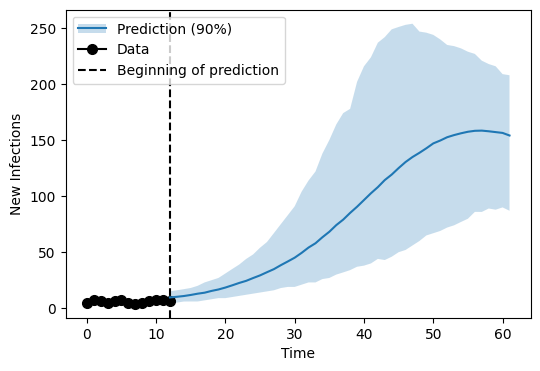

In [142]:
fig = plt.figure(figsize=(6, 4))

ax = fig.add_subplot(1, 1, 1)

initial_times = np.arange(len(infection_history))
l0, = ax.plot(initial_times, infection_history, 'o-', color='k', markersize=7, label='Data')

l3 = ax.axvline(initial_times[-1], color='k', ls='--', label='Beginning of prediction')

simulations = np.asarray(simulations)
predict_times = np.arange(initial_times[-1], initial_times[-1] + len(simulations[0, :]))
median = np.mean(simulations, axis=0)
lower = np.percentile(simulations, 5, axis=0)
upper = np.percentile(simulations, 95, axis=0)

l1, = ax.plot(predict_times, median)
l2 = ax.fill_between(predict_times, lower, upper, alpha=0.25)


ax.legend(( (l1, l2), l0, l3) , ['Prediction (90%)', 'Data', 'Beginning of prediction'])

ax.set_xlabel('Time')
ax.set_ylabel('New Infections')

In [138]:
mu_samples = [8.0, 7.9, 8.1]
sigma_samples = [5.0, 5.1, 5.2]

##### Precise knowledge
mu_samples = scipy.stats.norm.rvs(8, 0.01, 100)
sigma_samples = scipy.stats.norm.rvs(5, 0.01, 100)
#####

m = PredictionModel(mu_samples, sigma_samples, 2, 10000)
infection_history = [5, 7, 6, 5, 6, 7, 5, 4, 5, 6, 7, 7, 6]

simulations = m.simulate_uncertainty(m.ws, infection_history, 50, 10)

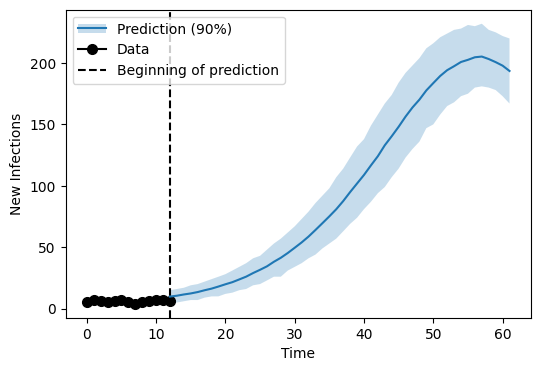

In [140]:
fig = plt.figure(figsize=(6, 4))

ax = fig.add_subplot(1, 1, 1)

initial_times = np.arange(len(infection_history))
l0, = ax.plot(initial_times, infection_history, 'o-', color='k', markersize=7, label='Data')

l3 = ax.axvline(initial_times[-1], color='k', ls='--', label='Beginning of prediction')

simulations = np.asarray(simulations)
predict_times = np.arange(initial_times[-1], initial_times[-1] + len(simulations[0, :]))
median = np.mean(simulations, axis=0)
lower = np.percentile(simulations, 5, axis=0)
upper = np.percentile(simulations, 95, axis=0)

# for simulation in simulations:
    # ax.plot(predict_times, simulation, color='tab:blue', alpha=0.005)

l1, = ax.plot(predict_times, median)
l2 = ax.fill_between(predict_times, lower, upper, alpha=0.25)


ax.legend(( (l1, l2), l0, l3) , ['Prediction (90%)', 'Data', 'Beginning of prediction'])

ax.set_xlabel('Time')
ax.set_ylabel('New Infections')
plt.show()